# Experiment Set B

In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard
from sklearn import preprocessing
from sklearn import metrics

# numpy compatibility issues.
for retry in range(5):
    try:
        import statsmodels.api as sm
        break
    except ImportError:
        if retry == 4:
            raise

# project import
import common

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.
C:\Anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Processing

In [9]:
# load all csv files of North-point site. Concatenate them..
df = common.load_df("../data/insead", "*21*.csv")
print(common.load_df.cache_info())

# preprocess.
df = common.remove_negatives(df)
df = common.identify_ct_shutdown(df)
df = common.replace_missing(df)
df = common.get_normalized_df(df, scale=(0.1, 1))

# remove sudden peaks
thresh = df.median()
df[df <= df.min()] = df.rolling(1*60*10, min_periods=1).median()

# Decompose time series.
df_decomposed = pd.DataFrame()
for col in df.columns:
    resp = sm.tsa.seasonal_decompose(df[col], freq=1*60*24)
    for part in ("seasonal", "trend", "resid"):
        col_name = "{0}_{1}".format(col, part)
        df_decomposed[col_name] = getattr(resp, part)

# drop null values at beginning & end
df_decomposed = df_decomposed.dropna()

CacheInfo(hits=1, misses=1, maxsize=None, currsize=1)


## Model Seasons

In [3]:
# manually select training and validaiton data.
batch_size = 200
train_df = df_decomposed["2017-01-02":"2017-01"]
validation_df = df_decomposed["2017-03-01":"2017-03-10"]

# The recipe. Let's model Trend
features = ["loadsys_seasonal", "drybulb_seasonal", "rh_seasonal", "cwrhdr_seasonal"]
target = ["cwshdr_seasonal"]
lookback = 8

# get data for keras
train_x, train_y = common.prepare_keras_data(train_df, features, target, lookback, batch_size)
validation_x, validation_y = common.prepare_keras_data(validation_df, features, target, lookback, batch_size)
train_x.shape, train_y.shape

## Prepare model
model = Sequential([
    LSTM(32*3, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    LSTM(32, stateful=True, return_sequences=True),
    LSTM(4, stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

In [10]:
for epoch in range(200):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras8")])
    model.reset_states()    
    if epoch % 20 == 0:
        print("At epoch ", epoch)

At epoch  0
At epoch  20
At epoch  40
At epoch  60
At epoch  80
At epoch  100
At epoch  120
At epoch  140
At epoch  160
At epoch  180


In [15]:
model.save("../output/keras8.h5")

In [5]:
model = load_model("../output/keras8.h5")

MSE:  3.82041271605e-07
MAPE:  14.7916179585


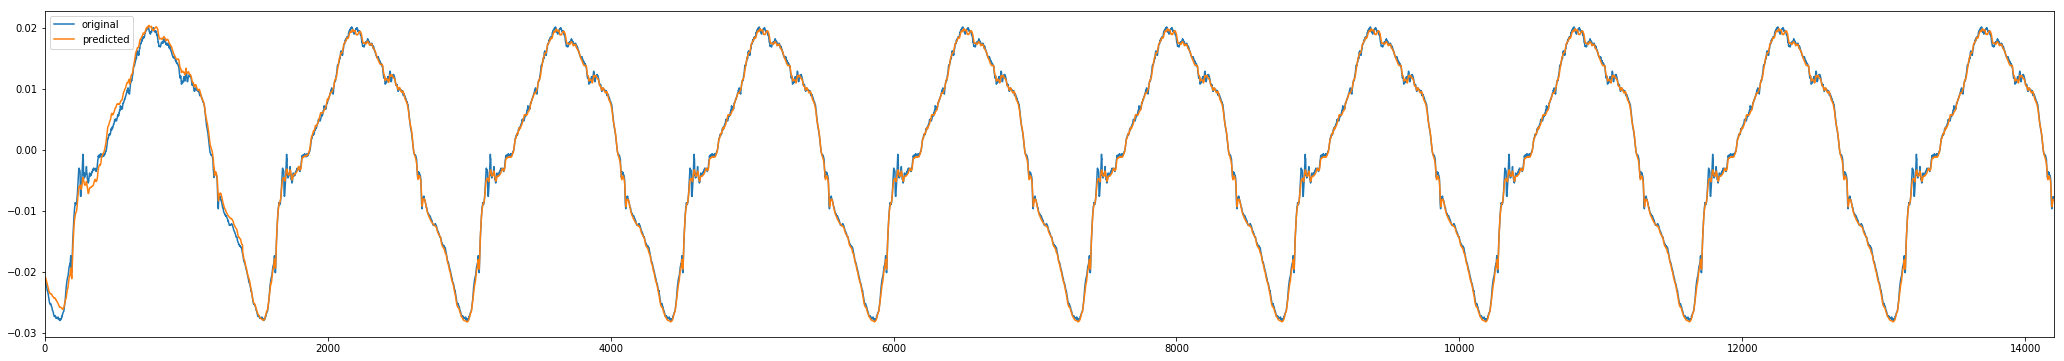

In [10]:
# Test the validation sample...
predicted_y = model.predict(validation_x, batch_size=batch_size) # predict
predicted_y = common.Reshape.inv_y(predicted_y) # reshape to normal (Numpy's origin shape)
validation_y = common.Reshape.inv_y(validation_y)

print("MSE: ", metrics.mean_squared_error(validation_y, predicted_y))
print("MAPE: ", common.mean_absolute_percent_error(validation_y, predicted_y))

plot_df = pd.DataFrame({"original": validation_y, "predicted": predicted_y})
ax = plot_df.plot(figsize=(36,6))

In [39]:
plot_df["SE"] =  plot_df.apply(lambda x: (x.original-x.predicted)**2, axis=1)
plot_df["APE"] = plot_df.apply(lambda x: 100 * np.abs((x.original-x.predicted) / x.original), axis=1)
plot_df.to_csv("../output/predicted.csv", index_label="id")

## Model Residue

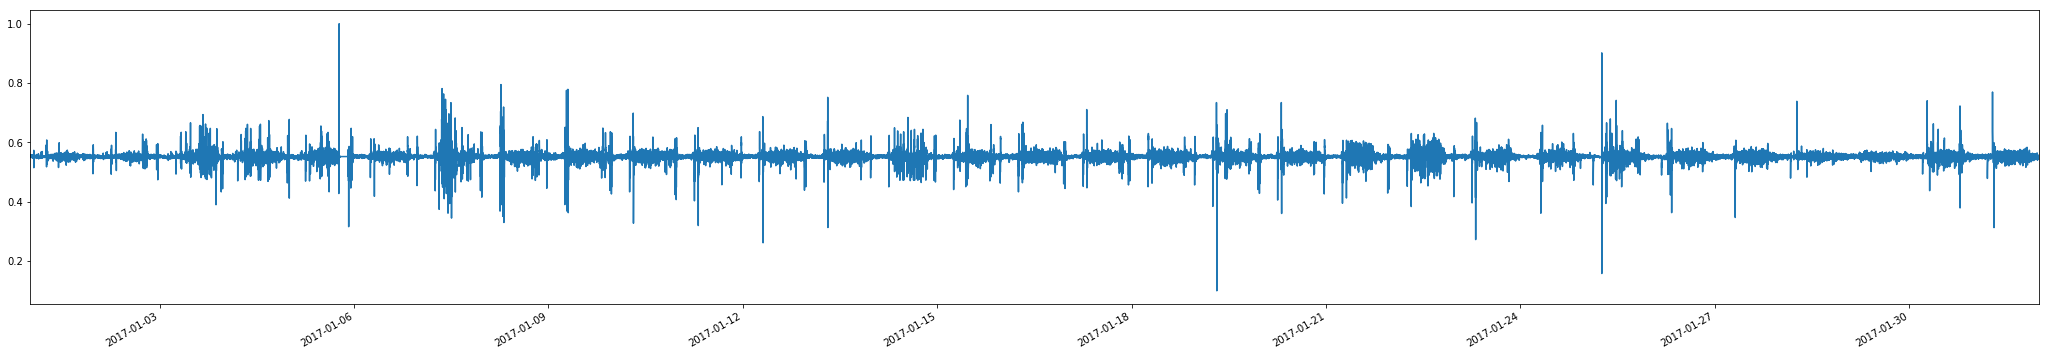

In [10]:
# manually select training and validaiton data.
batch_size = 200
train_df = df_decomposed["2017-01-01":"2017-01"]
train_df -= train_df.shift(1)
train_df = train_df[1:]
train_df = train_df.apply(lambda x: np.log(x+1))
train_df = common.get_normalized_df(train_df, scale=(0.1, 1))

validation_df = df_decomposed["2017-02-01":"2017-02-01"]
validation_df -= validation_df.shift(1)
validation_df = validation_df[1:]
validation_df = validation_df.apply(lambda x: np.log(x+1))
validation_df = common.get_normalized_df(train_df, scale=(0.1, 1))


fig, ax = plt.subplots(1,1, figsize=(36,6))
train_df.cwshdr_resid.plot(ax=ax)

In [11]:
# The recipe. Let's model Trend
features = ["loadsys_resid", "drybulb_resid", "rh_resid", "ct1kw_resid", "ct2akw_resid", "systotpower_resid"]
target = ["cwshdr_resid"]
lookback = 5

# get data for keras
train_x, train_y = common.prepare_keras_data(train_df, features, target, lookback, batch_size)
validation_x, validation_y = common.prepare_keras_data(validation_df, features, target, lookback, batch_size)
train_x.shape, train_y.shape

## Prepare model
model = Sequential([
    LSTM(25, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    LSTM(10, stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

In [ ]:
for epoch in range(20000):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras11")])
    model.reset_states()    
    if epoch % 1000 == 0:
        print("At epoch ", epoch)

In [ ]:
model.save("../")